<a id="introduction" ></a>
# Introduction

In this notebook, I will use linear regression and light GBM to predict the insurance charges. LightGBM is an ensembling model, which involves sequentially training models, where each new model focuses on the data points that were misclassified by previous models. The difference between LightGBM and XGBoost is:

- XGBoost uses a level-wise tree growth algorithm, where it splits the tree level by level. 
    
- LightGBM employs a leaf-wise (best-first) tree growth algorithm, where it chooses the leaf it believes will yield the best split next, regardless of the level of the tree.
    
In short, the difference between them is similar to breadth-first-search and depth-first-search in graph theory. That's why LGBM is very fast compared to XGBoost.

## Table of Contents
1. [Introduction](#introduction)
2. [Data loading](#data-load)
3. [Univariate analysis](#univariate)
4. [Bivariate analysis](#bivariate)
5. [Utilities](#utilities)
6. [Training and validating models](#training-validating)
7. [Linear regression model](#linear)
8. [LGBM model](#lgbm)
9. [Prepare the test set](#prepare-test)
10. [LGBM on test set](#model-test)
11. [Important features](#important-features)
12. [Conclusion](#conclusion)

<a id="data-load" ></a>
# Data loading

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df = pd.read_csv('data/insurance.csv')

In [3]:
df.shape

(1338, 7)

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

<a id="univariate" ></a>
# Univariate analysis

In [7]:
num_features = ['age', 'bmi', 'children']
cat_features = ['sex', 'smoker', 'region']

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

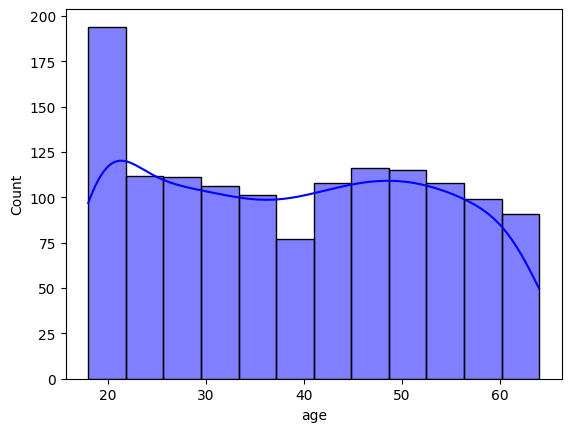

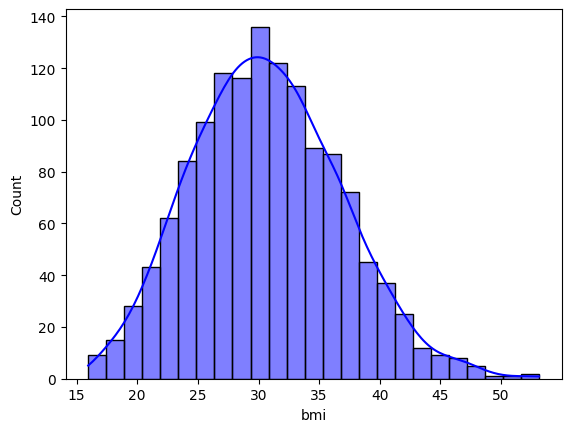

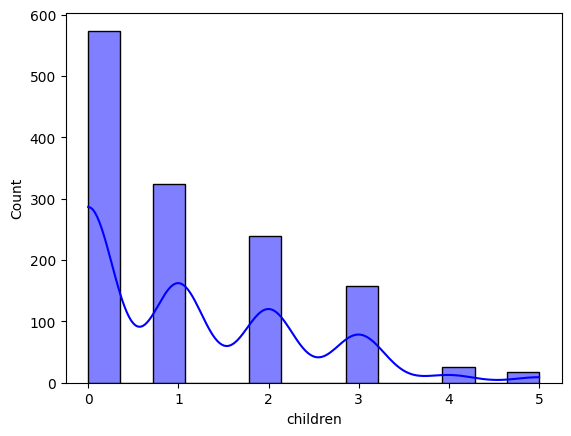

In [9]:
for feature in num_features:
    sns.histplot(
        data = df,
        x = feature,
        kde = True,
        color = 'blue'
    )
    plt.show()

From the histogram plots, we can see that:
- The number of records with age $\approx$ 20 is highest, and age $\approx$ is lowest.
- The BMI histogram is resonable symmetric and bell-shaped with center arond 30. It is a right-skewed. This implies there are people with high BMI.
- For children, most of records have the number of children 0, and it decreases when the number of children goes up.

We will check if there are outliers for numerical features

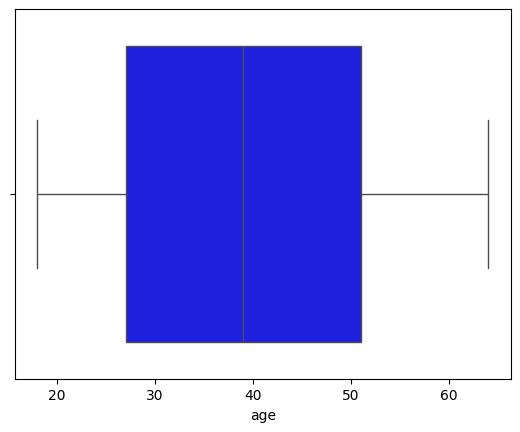

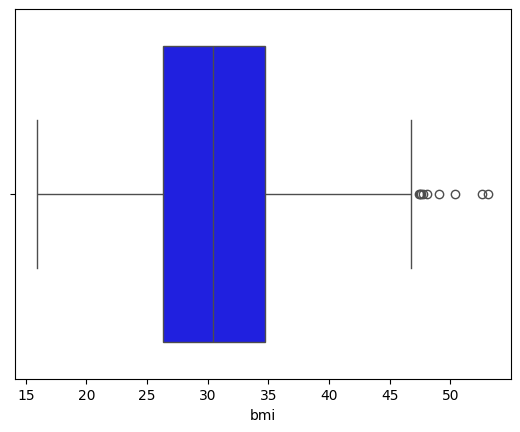

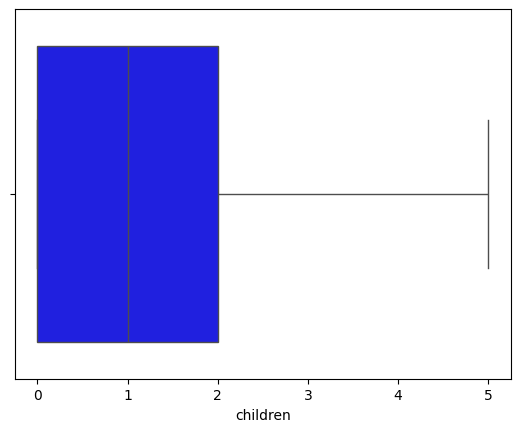

In [10]:
for feature in num_features:
    sns.boxplot(
        data = df,
        x = feature,
        color ='blue'
    )
    plt.show()

For BMI, there are a few outliers whose BMI > 45. This indicates extremely obese category, and we should not remove it as it is an important factor to decide the insurance charges.

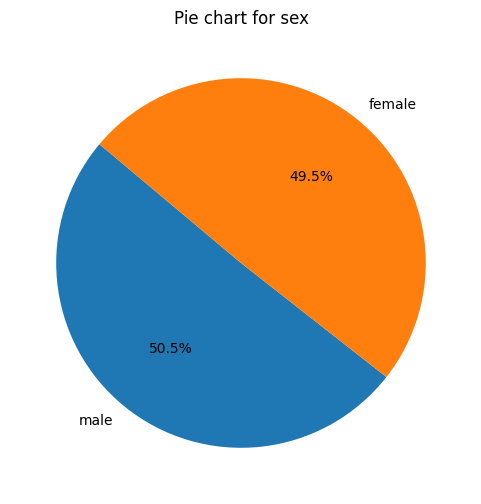

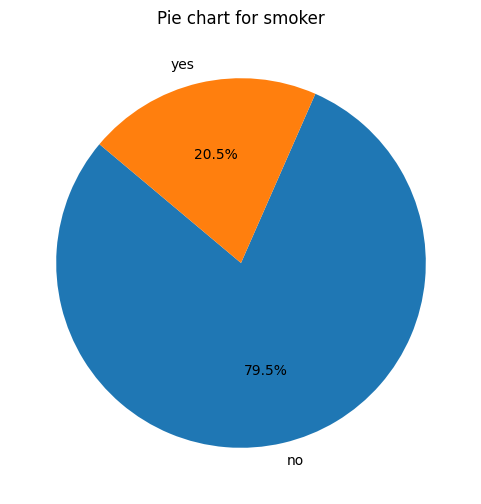

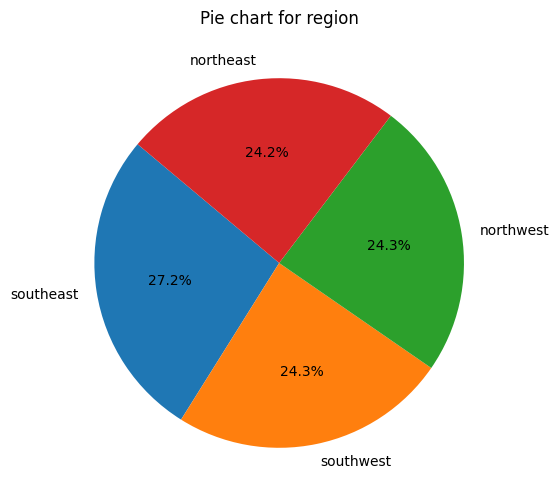

In [11]:
for feature in cat_features:
    counts = df[feature].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie chart for {feature}')
    plt.show()

The pie chart for sex and region are quite balanced. However, almost 80% are non-smokers. 

<a id="bivariate" ></a>
# Bivariate analysis

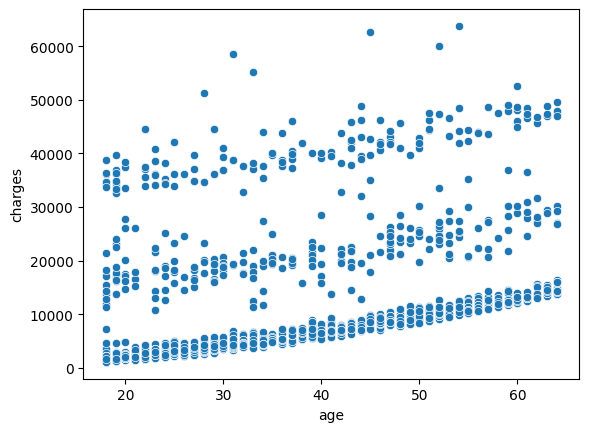

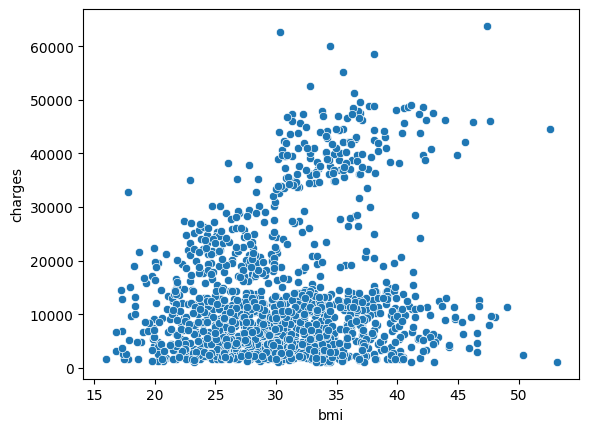

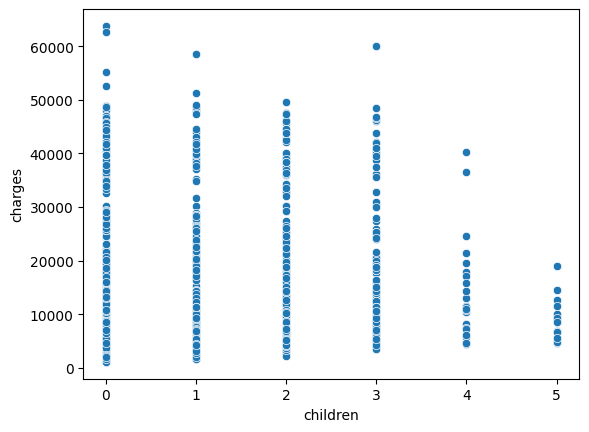

In [12]:
for feature in num_features:
    sns.scatterplot(
        data = df,
        x = feature,
        y = 'charges'
    )
    plt.show()

We can see that: 
- the charge tends to increase when the age and bmi increase
- records with high number of children tends to have less charges 
- there are unusual high values (more than 50.000) for charges when the bmi and age are in normal range.

In [13]:
df.loc[df['charges']>50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


There are 6 records with unusual high charges, and all of them are smokers.

Let's check it with spearman's correlation (for monotonic relationships) and pearson's correlation (for linear relationships).

In [14]:
def corr(corr_type):
    for feature in num_features:
        corr, p_value = corr_type(df[feature], df['charges'])
        print('========================')
        print(f'{corr_type} correlation for {feature} and charges: {corr}')
        print(f'p value: {p_value}')

In [15]:
from scipy.stats import spearmanr, pearsonr

In [16]:
corr(spearmanr)

<function spearmanr at 0x1274bbac0> correlation for age and charges: 0.5343921337718459
p value: 1.130692027803638e-99
<function spearmanr at 0x1274bbac0> correlation for bmi and charges: 0.11939590358331145
p value: 1.1926059544526875e-05
<function spearmanr at 0x1274bbac0> correlation for children and charges: 0.13333894319168216
p value: 9.8468061329973e-07


The strongest and most significant relationship is between age and charges, suggesting that age is a more important predictor of charges compared to BMI and the number of children.

In [17]:
corr(pearsonr)

<function pearsonr at 0x1274bb880> correlation for age and charges: 0.2990081933306478
p value: 4.8866933317182706e-29
<function pearsonr at 0x1274bb880> correlation for bmi and charges: 0.19834096883362926
p value: 2.45908553511648e-13
<function pearsonr at 0x1274bb880> correlation for children and charges: 0.06799822684790453
p value: 0.012852128520136856


Again, age and charges some some linear relationship, but not very clear.

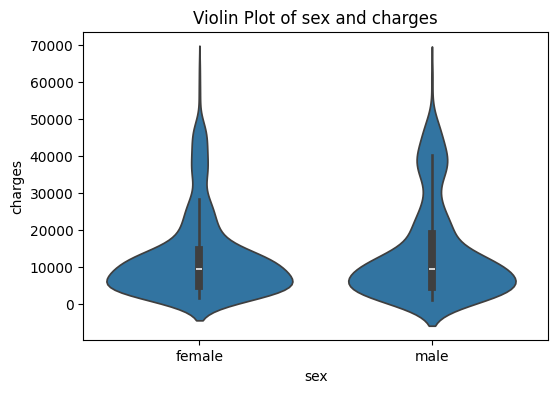

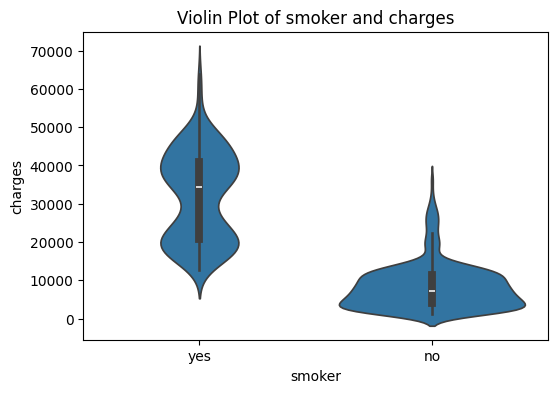

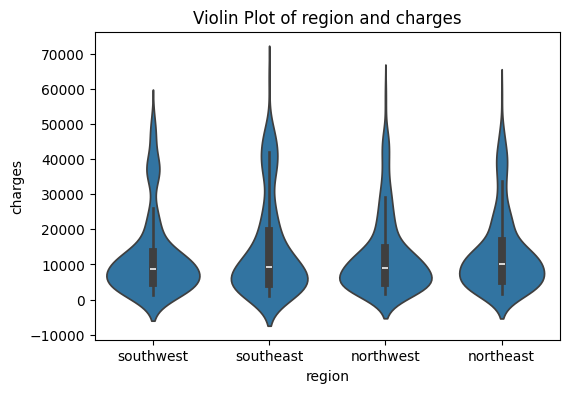

In [18]:
for feature in cat_features:
    plt.figure(figsize=(6, 4))
    sns.violinplot(y='charges',x=feature, data = df)
    plt.title(f'Violin Plot of {feature} and charges')
    plt.show()

The violin plots for region and sex are quite balanced. For smoker, non-smokers are charged less compared to smokers.

<a id="preprocessing" ></a>
# Encoding and Scaling on the training set

In this section, we will label encode categorical features and standard scale numerical features. We should do this only on the training set, then save and use it on the test set.

In [19]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2, shuffle=True, random_state=42)

In [20]:
print(df_train.shape)
print(df_test.shape)

(1070, 7)
(268, 7)


In [21]:
from sklearn.preprocessing import LabelEncoder
# Label encoding function
def label_encoding(df, cat_features):
    # Copy the dataframe to avoid changes to the original
    df_processed = df.copy()
    encoders={}
    
    # Handle categorical features
    for feature in cat_features:
        # Fill missing values with a specific label -1
        df_processed[feature] = df_processed[feature].fillna(-1)
        
        # Define valid_index
        valid_index = df_processed[feature] != -1
        encoder = LabelEncoder()
        # Label encoding with valid_index
        df_processed.loc[valid_index, feature] = encoder.fit_transform(df_processed.loc[valid_index, feature])
        
        # Ensure the dtype is integer for the manual label
        df_processed[feature] = df_processed[feature].astype(int)
        encoders[feature] = encoder  
        
    return df_processed, encoders

In [22]:
df_train, encoders = label_encoding(df_train, cat_features)

In [23]:
df_train

,age,sex,bmi,children,smoker,region,charges
560,46,0,19.950,2,0,1,9193.83850
1285,47,0,24.320,0,0,0,8534.67180
1142,52,0,24.860,0,0,2,27117.99378
969,39,0,34.320,5,0,2,8596.82780
486,54,0,21.470,3,0,1,12475.35130
...,...,...,...,...,...,...,...
1095,18,0,31.350,4,0,0,4561.18850
1130,39,0,23.870,5,0,2,8582.30230
1294,58,1,25.175,0,0,0,11931.12525
860,37,0,47.600,2,1,3,46113.51100


In [24]:
from sklearn.preprocessing import StandardScaler
def train_scaler(df, num_features):
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    return scaler

In [25]:
scaler = train_scaler(df_train, num_features)

In [26]:
df_train

,age,sex,bmi,children,smoker,region,charges
560,0.472227,0,-1.756525,0.734336,0,1,9193.83850
1285,0.543313,0,-1.033082,-0.911192,0,0,8534.67180
1142,0.898745,0,-0.943687,-0.911192,0,2,27117.99378
969,-0.025379,0,0.622393,3.202629,0,2,8596.82780
486,1.040918,0,-1.504893,1.557100,0,1,12475.35130
...,...,...,...,...,...,...,...
1095,-1.518194,0,0.130717,2.379865,0,0,4561.18850
1130,-0.025379,0,-1.107579,3.202629,0,2,8582.30230
1294,1.325264,1,-0.891539,-0.911192,0,0,11931.12525
860,-0.167551,0,2.820864,0.734336,1,3,46113.51100


<a id="utilities" ></a>
# Utilities

This section contains several utilized functions before modelling, for example: model_validation, cross_validation, residuals plots and hyper-tuning.

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [28]:
# Model evaluation
def model_evaluation(estimator, X, y):
    predicted_values = estimator.predict(X)
    MSELoss = mean_squared_error(predicted_values, y)
    RMSELoss = np.sqrt(MSELoss)
    r2score = r2_score(predicted_values, y)
    print("RMSE loss: ", RMSELoss)
    print("R2 score: ", r2score)
    return predicted_values

# Cross validation
def cross_validation(estimator, X, y, score = 'r2', n = 5):
    validate = cross_val_score(estimator, X, y, scoring = score, cv = n)
    print("Mean valiation R2 score: ", validate.mean())

# Histplot of the residuals
def histplot(residuals):
    sns.histplot(
        data=residuals,
        kde=True,
        color='red'
    )

# Plot the residuals
def plot(residuals):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(residuals)), residuals, color='blue') 
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.show()

# Hypertunning
def hyper_tune(estimator, X, y, param_grid, score = 'r2', n = 5):
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=score,
        cv=n
    )
    grid_search.fit(X, y)
    best_score = grid_search.best_score_
    print("Best R2 score: ", best_score)
    return grid_search.best_estimator_

<a id="training-validating" ></a>
# Training and validating models

For modeling, we will do several steps:
- Divide into train and validation set, where validation set is used for validation and hyper-tuning
- Develop linear regression and LGBM model
- Check the residuals plots
- Hypertune the model

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = df_train.drop(columns=['charges'], axis=1).values
y = df_train['charges'].values
print(X.shape)
print(y.shape)

(1070, 6)
(1070,)


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, shuffle=True, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(802, 6)
(802,)
(268, 6)
(268,)


<a id="linear" ></a>
# Linear regression

When there are linear relationship, linear regression is a good starting model. We can further increase the performance by increasing the degree of polynomial features.

In [32]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [33]:
y_val_pred = model_evaluation(linear_model, X_val, y_val)

RMSE loss:  6764.7120154572085
R2 score:  0.5891280874339074


The R2 score 59 is not very good. We can hyper-tune the model as follows.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

LR_pipeline = Pipeline([
    ('poly_feat', PolynomialFeatures()),
    ('model', LinearRegression())
])
param_grid = {'poly_feat__degree': [2, 3]}
LR_best= hyper_tune(LR_pipeline, X_val, y_val, param_grid)

Best R2 score:  0.6788215036908526


In [35]:
LR_best.fit(X_train, y_train)

Pipeline(steps=[('poly_feat', PolynomialFeatures()),
                ('model', LinearRegression())])

In [36]:
y_val_pred = model_evaluation(LR_best, X_val, y_val)

RMSE loss:  5626.152793465965
R2 score:  0.7636802358743771


The R2 score is now good. Let's check the residuals plot

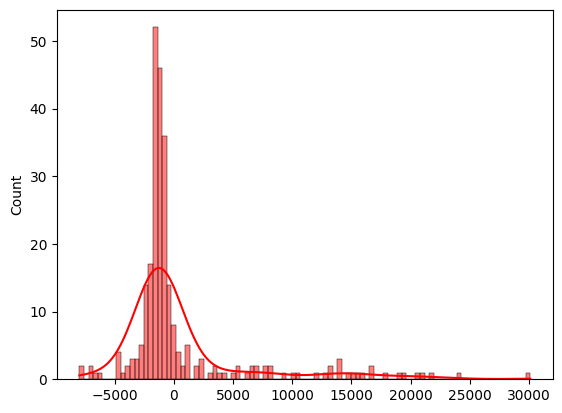

In [37]:
residuals = y_val - y_val_pred
histplot(residuals)

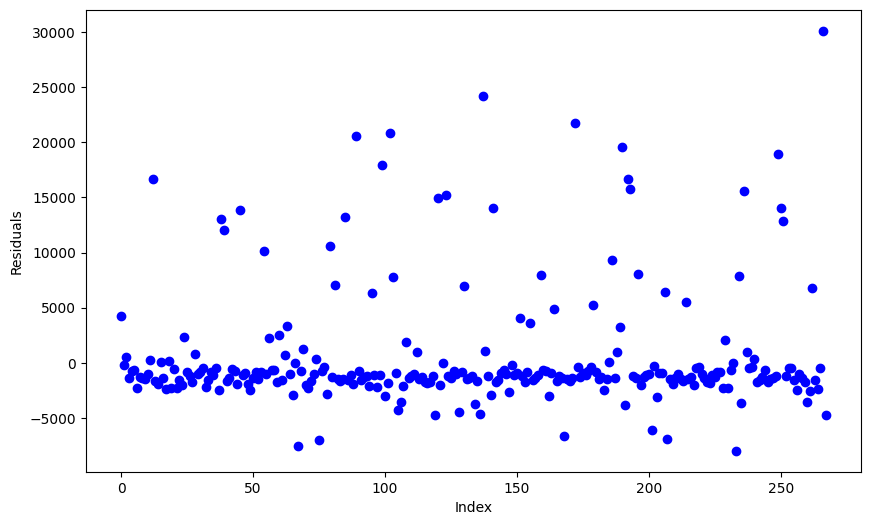

In [38]:
plot(residuals)

From the plot of residuals, it seems the distribution of residuals is heavily right-skewed, and it usually under-estimate the charges.

<a id="lgbm" ></a>
# LightGBM model

In [39]:
!pip install -qqq lightgbm

In [40]:
from lightgbm import LGBMRegressor

In [41]:
gbm = LGBMRegressor(num_leaves = 31, verbose=-1)
cross_validation(gbm, X_train, y_train)

Mean valiation R2 score:  0.8386029675448953


The mean cross-validation score is 0.83.

In [42]:
gbm.fit(X_train, y_train)

LGBMRegressor(verbose=-1)

In [43]:
y_val_pred = model_evaluation(gbm, X_val, y_val)

RMSE loss:  5565.723348212733
R2 score:  0.7830547396104371


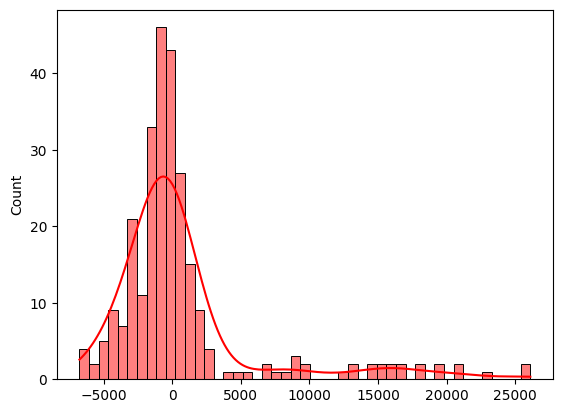

In [44]:
residuals = y_val - y_val_pred
histplot(residuals)

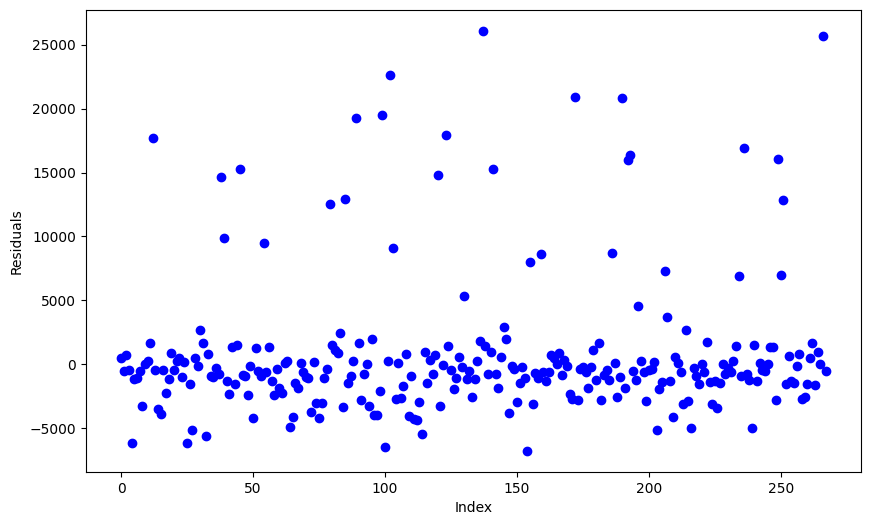

In [45]:
plot(residuals)

Again, we can see that it is heavily right-skewed. Let's hyper-tune this.

In [46]:
param_grid = {
    'num_leaves': [25, 31 ,40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 120, 150, 200, 300],
    'verbose':[-1]
}

best_gbm = hyper_tune(gbm, X_val, y_val, param_grid)

Best R2 score:  0.7709949726376525


In [47]:
best_gbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, num_leaves=25, verbose=-1)

In [48]:
y_val_pred = model_evaluation(best_gbm, X_val, y_val)

RMSE loss:  5390.147159303208
R2 score:  0.79052868405486


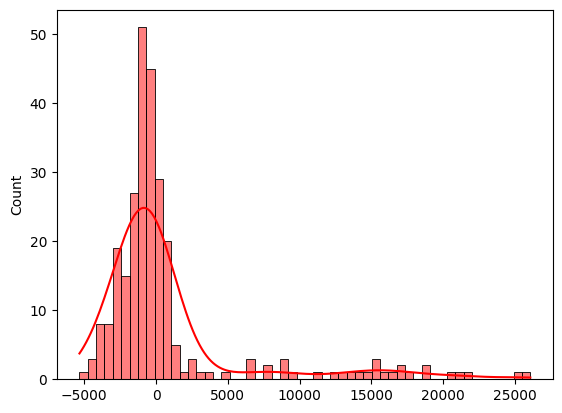

In [49]:
residuals = y_val - y_val_pred
histplot(residuals)

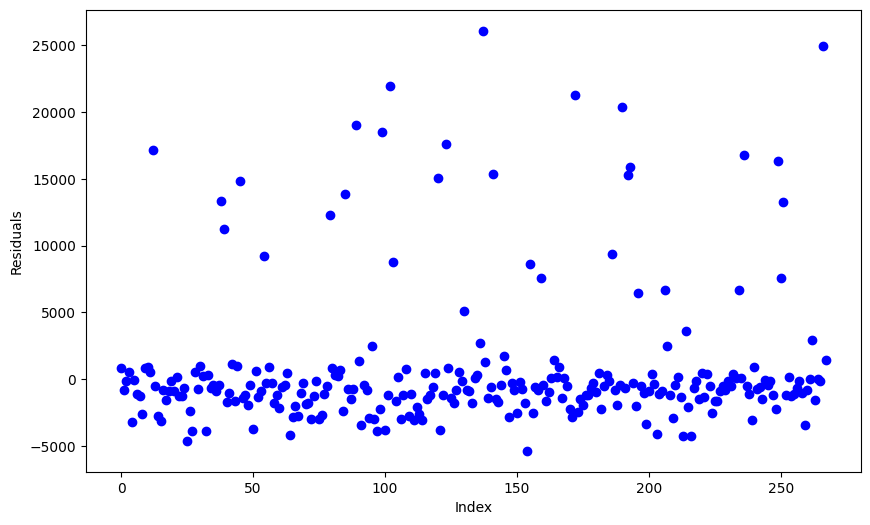

In [50]:
plot(residuals)

There are several unusual high charges are not capture well by the model, as it might be related to medical cost or treatment history, which is not available in the dataset.

<a id="prepare-test" ></a>
# Preprocessing on test set

In [51]:
def label_encoding_test(df, cat_features, encoders):
    df_encoded = df.copy()

    for feature in cat_features:
        # Mapping of known labels to encoded values
        known_labels_map = {label: encoders[feature].transform([label])[0] for label in encoders[feature].classes_}

        # Function to encode a single value
        def encode_value(val):
            if pd.isna(val) or val not in known_labels_map:
                return -1  # Handle unseen labels and NaNs
            else:
                return known_labels_map[val]

        # Apply encoding to the column
        df_encoded[feature] = df[feature].apply(encode_value).astype(int)

    return df_encoded

In [52]:
df_test = label_encoding_test(df_test, cat_features, encoders)

In [53]:
df_test

,age,sex,bmi,children,smoker,region,charges
764,45,0,25.175,2,0,0,9095.06825
887,36,0,30.020,0,0,1,5272.17580
890,64,0,26.885,0,1,1,29330.98315
1293,46,1,25.745,3,0,1,9301.89355
259,19,1,31.920,0,1,1,33750.29180
...,...,...,...,...,...,...,...
109,63,1,35.090,0,1,2,47055.53210
575,58,0,27.170,0,0,1,12222.89830
535,38,1,28.025,1,0,0,6067.12675
543,54,0,47.410,0,1,2,63770.42801


In [54]:
df_test[num_features] = scaler.transform(df_test[num_features])

In [55]:
df_test

,age,sex,bmi,children,smoker,region,charges
764,0.401140,0,-0.891539,0.734336,0,0,9095.06825
887,-0.238638,0,-0.089461,-0.911192,0,1,5272.17580
890,1.751782,0,-0.608453,-0.911192,1,1,29330.98315
1293,0.472227,1,-0.797177,1.557100,0,1,9301.89355
259,-1.447107,1,0.225079,-0.911192,1,1,33750.29180
...,...,...,...,...,...,...,...
109,1.680696,1,0.749865,-0.911192,1,2,47055.53210
575,1.325264,0,-0.561272,-0.911192,0,1,12222.89830
535,-0.096465,1,-0.419729,-0.088428,0,0,6067.12675
543,1.040918,0,2.789410,-0.911192,1,2,63770.42801


<a id="model-test" ></a>
# Modelling on test set

In [56]:
X_test = df_test.drop(columns=['charges'],axis=1).values
y_test = df_test['charges']

In [57]:
y_test_pred = model_evaluation(best_gbm, X_test, y_test)

RMSE loss:  4470.409005303235
R2 score:  0.8521369860519454


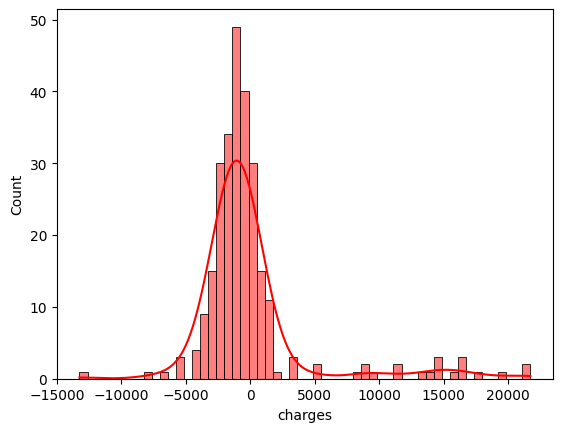

In [58]:
residuals = y_test - y_test_pred
histplot(residuals)

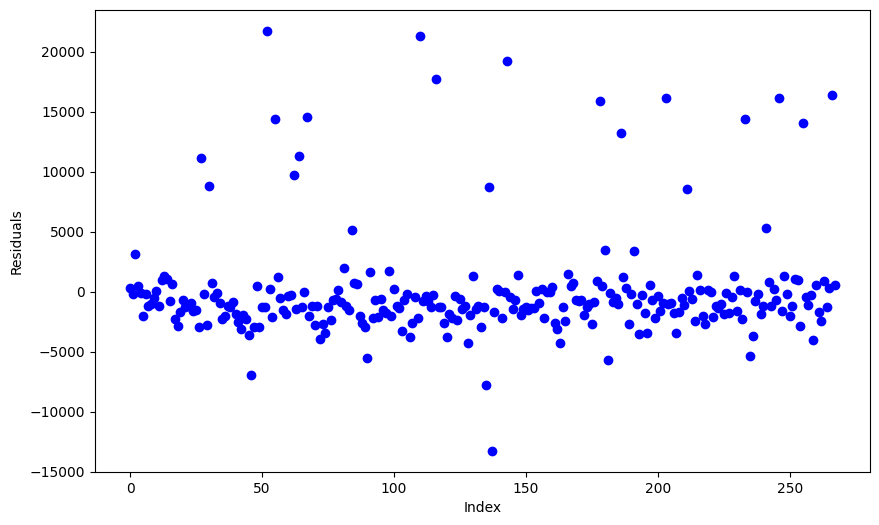

In [59]:
plot(residuals)

The histogram of the residuals looks reasonably symmetric and bell-shaped. The residuals also fluctuate around 0. And those indicate that LGBM is a good model for the problem.

<a id="important-features" ></a>
# Important features

In [60]:
lst = df_train.drop(columns=['charges']).columns.to_list()

def get_important_features(best_gbm, top_n):
    
    # Get feature importances
    importance = best_gbm.feature_importances_

    # Get indices of sorted importances
    sorted_indices = np.argsort(importance)[::-1]
    
    top_n_features = [lst[index] for index in sorted_indices[:top_n]]
    print(f"Top {top_n} important features: ", top_n_features)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_indices)), importance[sorted_indices], align='center')
    plt.yticks(range(len(sorted_indices)), importance)
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances in Classifier Model")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
    plt.show()

Top 3 important features:  ['bmi', 'age', 'region']


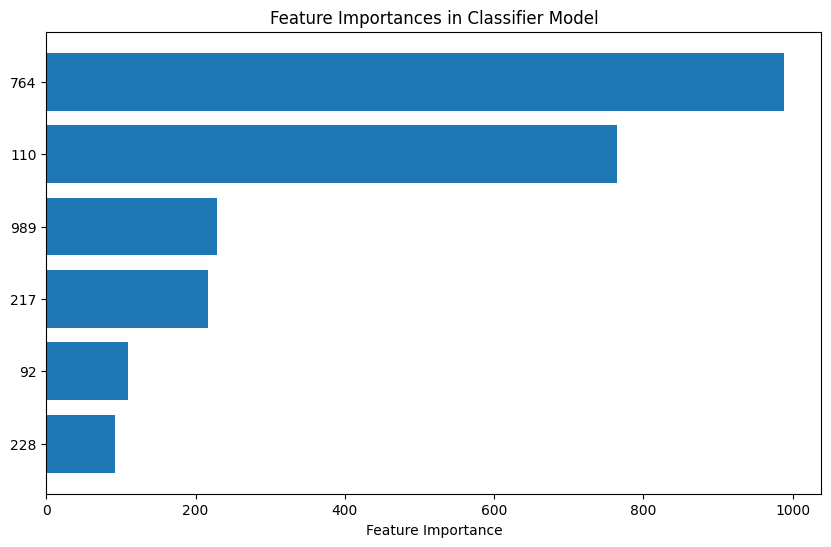

In [61]:
# Top 3 important features
get_important_features(best_gbm, top_n=3)

<a id="conclusion" ></a>
# Conclusion

LGBM is a good model for the problem with R2 score is 0.85. The top 3 important features are: bmi, age and region. The result can be better if we have more information about height, weight, history of medial treatment.